In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, nbinom
import seaborn as sns
import pandas as pd

# Helper functions

In [2]:
def relu(x, b=0):
    return np.clip(x-b, 0, np.inf)

def normalize(x, ax=1):
    return (x - np.mean(x, axis=ax, keepdims=True))/ (1e-8+np.std(x, axis=ax, keepdims=True))

def pairwise_correlations_centered(x):
    return np.corrcoef(x-np.mean(x, 0))

In [3]:
def get_spiking(acts):
    spikes = poisson(scale*input_acts[i]).rvs()
    return spikes

# poisson(scale*input_acts[i]).rvs()
# # nbinom(1e-8+input_acts[i] / (1.0/p - 1.0), p).rvs()

# scale = 0.1
# print(np.mean([np.corrcoef(poisson(scale*input_acts[i]).rvs(), poisson(scale*input_acts[i]).rvs())[0, 1] for i in range(100)]))
# print(np.mean([np.corrcoef(poisson(scale*acts[i]).rvs(), poisson(scale*acts[i]).rvs())[0, 1] for i in range(100)]))

# p = 0.1
# print(np.mean([np.corrcoef(nbinom(1e-8+input_acts[i] / (1.0/p - 1.0), p).rvs(), nbinom(1e-8+input_acts[i] / (1.0/p - 1.0), p).rvs())[0, 1] for i in range(100)]))
# print(np.mean([np.corrcoef(nbinom(1e-8+acts[i] / (1.0/p - 1.0), p).rvs(), nbinom(1e-8+acts[i] / (1.0/p - 1.0), p).rvs())[0, 1] for i in range(100)]))

In [4]:
def distance(a, b, maximum):
    dist = np.abs(a - b)
    dist = min(dist, np.abs(maximum-dist))
    return dist

# Dynamics function

In [5]:
def run_dynamics(
    W, inputs, divisive_normalization=30.0, dt=0.1,
    n_zero_input=0
    ):
    
    preacts = np.zeros([num_states, N_bar])
    acts = np.zeros([num_states, N_bar])
    acts_over_time = np.zeros([steps+n_zero_input, num_states, N_bar])
    for s in range(steps):
        preacts = preacts*(1-divisive_normalization*np.sum(acts, axis=1, keepdims=True)/N_bar*dt) + dt*np.matmul(acts, W)+dt*inputs
        acts = relu(preacts)
        final_preacts = preacts.copy()
        final_acts = acts.copy()
        acts_over_time[s] = final_acts
    for s in range(n_zero_input):
        preacts = preacts*(1-divisive_normalization*np.sum(acts, axis=1, keepdims=True)/N_bar*dt) + dt*np.matmul(acts, W)
        acts = relu(preacts)
        acts_over_time[steps+s] = acts.copy()
    return final_preacts, final_acts, acts_over_time

# Initialization

In [6]:
# Parameters
N_inp = 2000
N_bar = 2000
num_states = 100
decay_constant = 0.2
steps = 100
b=10.0 # More positive, more diagonal
divisive_normalization = 30.0
dt = 0.1
rec_strength = 10.0 #8.0
input_strength = 1.0
narrow_search_factor = 0.0
wide_search_factor = 1.0
plasticity_bias = -0.7 
lr = 40.0

cache_states = [n*10 for n in range(10)]

In [7]:
# Initialize weight matrices
W_reconstruct = np.zeros([N_inp, N_bar])
rand_J = np.random.randn(N_bar, N_bar)
W_rec = rec_strength*(rand_J / np.sqrt(N_bar)) - (b / N_bar)
W_fantasy = np.zeros([N_bar])

In [8]:
# Make place inputs
inputs = np.zeros([num_states, N_inp])
for s in range(num_states):
    peak = int(s / float(num_states) * N_inp)
    for n in range(N_inp):
        dist = distance(n, peak, N_inp)
        inputs[s, n] = np.exp(-(dist/(N_inp*decay_constant)))
inputs = inputs - np.mean(inputs, axis=1, keepdims=True)
inputs = inputs / np.std(inputs, axis=1, keepdims=True)

# Example Activity

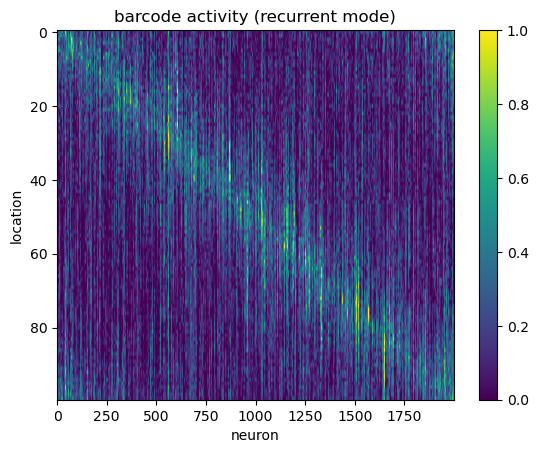

In [10]:
_, acts, acts_over_time = run_dynamics(W_rec, input_strength*inputs+0*W_fantasy, divisive_normalization=divisive_normalization)

plt.imshow(acts, vmin=0, vmax=1, aspect='auto')
plt.xlabel("neuron")
plt.ylabel("location")
plt.colorbar()
plt.title("barcode activity (recurrent mode)")
plt.show()


In [11]:
acts_over_time.shape

(100, 100, 2000)

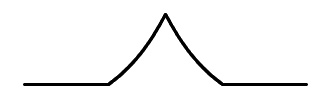

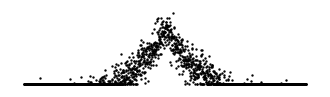

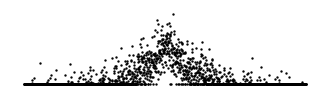

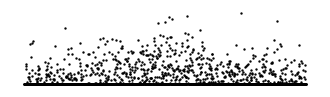

In [26]:
for t in [0, 1, 2, 99]:
    fig, ax = plt.subplots(figsize=(4,1))
    plt.scatter(
        np.arange(N_bar), acts_over_time[t, num_states//2],
        color='black', s=0.5
        )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.show()

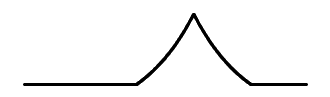

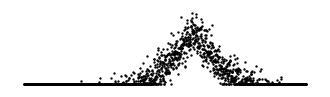

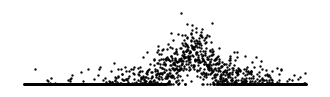

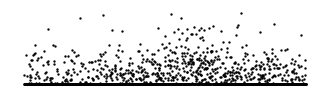

In [28]:
for t in [0, 1, 2, 99]:
    fig, ax = plt.subplots(figsize=(4,1))
    plt.scatter(
        np.arange(N_bar), acts_over_time[t, num_states//2+10],
        color='black', s=0.5
        )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.show()